# Reconstruct Kimberlites

The kimberlite dataset contains ages attached to the kimberlite eruptions. We reconstruct their palaeo-locations back to their eruption age using `gplately`.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import gplately
from slabdip import SlabDipper
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
import stripy

In [2]:
# Call GPlately's DataServer object and download the plate model
gdownload = gplately.download.DataServer("Clennett2020")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use the PlateReconstruction object to create a plate motion model
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Set time to present day for plotting
time = 0

# Call the PlotTopologies object
gplot = gplately.PlotTopologies(model, coastlines, continents, COBs, time=time)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
# read in condensed kimberlite data
df_kimb = pd.read_excel("data/kimberlites_condensed.xlsx")
df_kimb = df_kimb[df_kimb['Age estimated RDM'] <= 170]
extent_globe = [-180,180,-90,90]

## Import shear wave tomography model

Shear wave velocity is the composite tomography model "SMEAN2" generated by [Becker and Boschi (2002)](https://doi.org/10.1029/2001gc000168).

> Becker, T. W., & Boschi, L. (2002). A comparison of tomographic and geodynamic mantle models. Geochemistry, Geophysics, Geosystems, 3(1), n/a-n/a. https://doi.org/10.1029/2001gc000168

In [4]:
tomo = gplately.Raster(filename="data/smean2_dvs.2.grd")

/Users/ben/miniforge3/envs/mapping/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


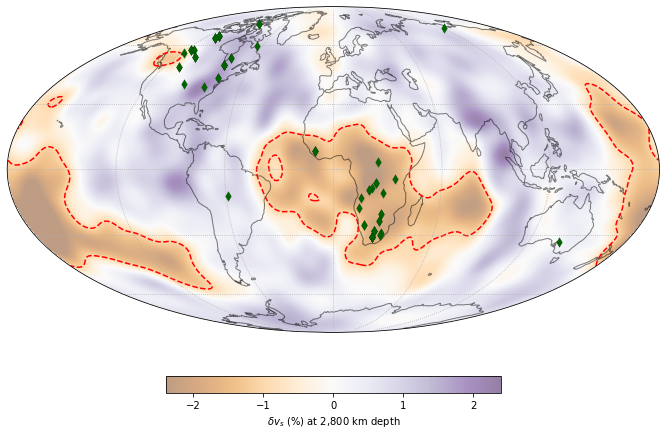

In [5]:
proj = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=proj)
ax.set_global()

vmax = np.percentile(np.abs(tomo.data), 99)
vmin = -vmax
im = ax.imshow(tomo.data, extent=extent_globe, cmap='PuOr', origin='lower', alpha=0.5,
               vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

ct = ax.contour(tomo.data, extent=extent_globe, origin='lower', levels=(-1,),
                colors='r', transform=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)

# ax.scatter(hotspot.lons, hotspot.lats, c='DarkRed', transform=ccrs.PlateCarree())

ax.scatter(df_kimb['Longitude'], df_kimb['Latitude'], s=50, c='DarkGreen' ,marker='d', edgecolor='k',
           linewidth=0.1, transform=ccrs.PlateCarree(), zorder=4)

ax.gridlines(linestyle=':')

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.1, label=r'$\delta v_s$ (%) at 2,800 km depth')

## Reconstruct to "birth age"

In [Torsvik _et al._ (2010)](https://doi.org/10.1038/nature09216) kimberlites are strongly associated with the edges of LLSVPs. We plot a similar map reconstructing kimberlites to the eruption age on top of the shear wave velocity anomaly.

> Torsvik, T. H., Burke, K., Steinberger, B., Webb, S. J., & Ashwal, L. D. (2010). Diamonds sampled by plumes from the core-mantle boundary. Nature, 466(7304), 352–355. https://doi.org/10.1038/nature09216


In [7]:
kimb = gplately.Points(model, df_kimb['Longitude'], df_kimb['Latitude'])

rlons, rlats = kimb.reconstruct_to_birth_age(df_kimb['Age estimated RDM'])

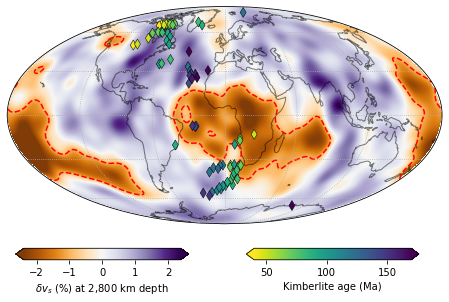

In [8]:
proj = ccrs.Mollweide(central_longitude=0)

fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=proj)
ax.set_global()

vmax = np.percentile(np.abs(tomo.data), 99)
vmin = -vmax
im = ax.imshow(tomo.data, extent=extent_globe, cmap='PuOr', origin='lower',
               vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

ct = ax.contour(tomo.data, extent=extent_globe, origin='lower', levels=(-1,),
                colors='r', transform=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)

# ax.scatter(hotspot.l   ons, hotspot.lats, c='DarkRed', transform=ccrs.PlateCarree())

sc = ax.scatter(rlons, rlats, s=50, c=df_kimb['Age estimated RDM'] ,marker='d', edgecolor='k', cmap='viridis_r',
           linewidth=0.5, transform=ccrs.PlateCarree(), zorder=4)

ax.gridlines(linestyle=':')

cax1 = fig.add_axes([0.15,0.0,0.3,0.04])
cax2 = fig.add_axes([0.55,0.0,0.3,0.04])

fig.colorbar(im, cax=cax1, orientation='horizontal', shrink=0.4, pad=0.1, extend='both', label=r'$\delta v_s$ (%) at 2,800 km depth')
fig.colorbar(sc, cax=cax2, orientation='horizontal', shrink=0.4, pad=0.1, extend='both', label='Kimberlite age (Ma)')

fig.savefig('kimberlites_velocity.pdf', dpi=300, bbox_inches='tight')

## Distance to LLSVP boundary

Find exactly how statistically significant the relationship between reconstructed kimberlite locations are against random continental locations

In [9]:
llsvp_coords = np.vstack(ct.allsegs[0])
llsvp_x, llsvp_y, llsvp_z = gplately.tools.lonlat2xyz(llsvp_coords[:,0], llsvp_coords[:,1])
llsvp_xyz = np.c_[llsvp_x, llsvp_y, llsvp_z] * gplately.EARTH_RADIUS

# put inside a K-D tree
llsvp_tree = cKDTree(llsvp_xyz)

# convert reconstructed coordinates to cartesian
rx, ry, rz = gplately.tools.lonlat2xyz(rlons, rlats)
rxyz = np.c_[rx, ry, rz] * gplately.EARTH_RADIUS

distance_to_contour, idx = llsvp_tree.query(rxyz)
dvs_interp = tomo.interpolate(rlons, rlats)
distance_to_contour[dvs_interp <= -1] = 0

In [10]:
# also randomly sample the continents to find the "baseline" distance to LLSVPs
mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4)

# extract the continent mask from present-day age grid
agegrid = gdownload.get_age_grid(0)
continent_raster = gplately.Raster(data=agegrid.data.mask.astype(float), extent=extent_globe)
in_continent = continent_raster.interpolate(np.rad2deg(mesh.lons), np.rad2deg(mesh.lats), method='nearest')
in_continent = in_continent.astype(bool)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


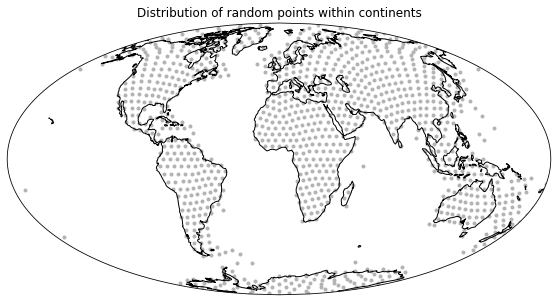

In [17]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(), title='Distribution of random points within continents')
ax1.set_global()
ax1.coastlines()

# continental tessellation
ax1.scatter(np.rad2deg(mesh.lons[in_continent]),
            np.rad2deg(mesh.lats[in_continent]), 
            transform=ccrs.Geodetic(), marker='.', color='0.7')

In [18]:
baseline_distance_to_contour, idx2 = llsvp_tree.query(mesh.points[in_continent] * gplately.EARTH_RADIUS)
dvs_interp = tomo.interpolate(np.degrees(mesh.lons[in_continent]), np.degrees(mesh.lats[in_continent]))
baseline_distance_to_contour[dvs_interp <= -1] = 0

# reconstruct back to Pangea
continent_points = gplately.Points(model, np.rad2deg(mesh.lons[in_continent]), np.rad2deg(mesh.lats[in_continent]))
clons, clats = continent_points.reconstruct(170, return_array=True)
cx, cy, cz = gplately.tools.lonlat2xyz(clons, clats)

reconstructed_distance_to_contour, idx3 = llsvp_tree.query(np.c_[cx,cy,cz] * gplately.EARTH_RADIUS)
dvs_interp = tomo.interpolate(clons, clats)
reconstructed_distance_to_contour[dvs_interp <= -1] = 0

In [19]:
def mask_data_extent(lons, lats, extent):
    mask_extent = np.zeros_like(lons, dtype=bool)
    mask_extent += lons < extent[0]
    mask_extent += lons > extent[1]
    mask_extent += lats < extent[2]
    mask_extent += lats > extent[3]
    mask_extent = np.invert(mask_extent)
    return mask_extent

extent_africa_kimberlites = [-30,60,-80,0]
extent_america_kimberlites = [-150,-50,30,85]


mask_africa_kimb  = mask_data_extent(kimb.lons, kimb.lats, extent_africa_kimberlites)
mask_america_kimb = mask_data_extent(kimb.lons, kimb.lats, extent_america_kimberlites)

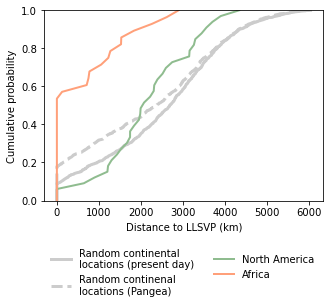

In [20]:
fig = plt.figure(figsize=(5,3.5))
ax1 = fig.add_subplot(111, xlabel='Distance to LLSVP (km)', ylabel='Cumulative probability', ylim=[0,1])

distance_contour_rbaseline = sorted(reconstructed_distance_to_contour)
distance_contour_baseline  = sorted(baseline_distance_to_contour) 
distance_contour_america   = sorted(distance_to_contour[mask_america_kimb])
distance_contour_africa    = sorted(distance_to_contour[mask_africa_kimb])
N_baseline = len(distance_contour_baseline)
N_america  = len(distance_contour_america)
N_africa   = len(distance_contour_africa)

ax1.plot(distance_contour_baseline, np.linspace(0,1,N_baseline), c='0.8', 
         linewidth=3, label='Random continental\nlocations (present day)')
ax1.plot(distance_contour_rbaseline, np.linspace(0,1,N_baseline), c='0.8', linestyle='--',
         linewidth=3, label='Random continenal\nlocations (Pangea)')
ax1.plot(distance_contour_america,  np.linspace(0,1,N_america), c='DarkSeaGreen', lw=2,
         label='North America')
ax1.plot(distance_contour_africa,   np.linspace(0,1,N_africa), c='LightSalmon', lw=2, label='Africa')

ax1.legend(ncol=2, bbox_to_anchor=(1,-0.2), frameon=False)
fig.savefig('kimberlite_CDF.pdf', bbox_inches='tight', dpi=300)

There is a statistically significant relationship between the LLSVP boundary and African kimberlites, but __not__ for North American kimberlites.

In [21]:
subduction_data = model.tessellate_subduction_zones(170, ignore_warnings=True)
sx, sy, sz = gplately.tools.lonlat2xyz(subduction_data[:,0], subduction_data[:,1])

trench_tree = cKDTree(np.c_[sx,sy,sz] * gplately.EARTH_RADIUS)
reconstructed_distance_to_trench, idx4 = trench_tree.query(np.c_[cx,cy,cz] * gplately.EARTH_RADIUS)